In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [2]:
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [4]:
# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

In [5]:
import os

lookup = dict()
reverselookup = dict()
count = 0
# Escape the backslashes with another backslash
for j in os.listdir('C:\\Users\\Md\\Downloads\\archive\\leapGestRecog\\leapGestRecog\\00\\'):
    if not j.startswith('.'):  # If running this code locally, this is to 
                                # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count += 1

print(lookup)


{'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


In [6]:
import os
import cv2
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir(r'C:\Users\Md\Downloads\archive\leapGestRecog\leapGestRecog\0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir(r'C:\Users\Md\Downloads\archive\leapGestRecog\leapGestRecog\0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = r'C:\Users\Md\Downloads\archive\leapGestRecog\leapGestRecog\0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

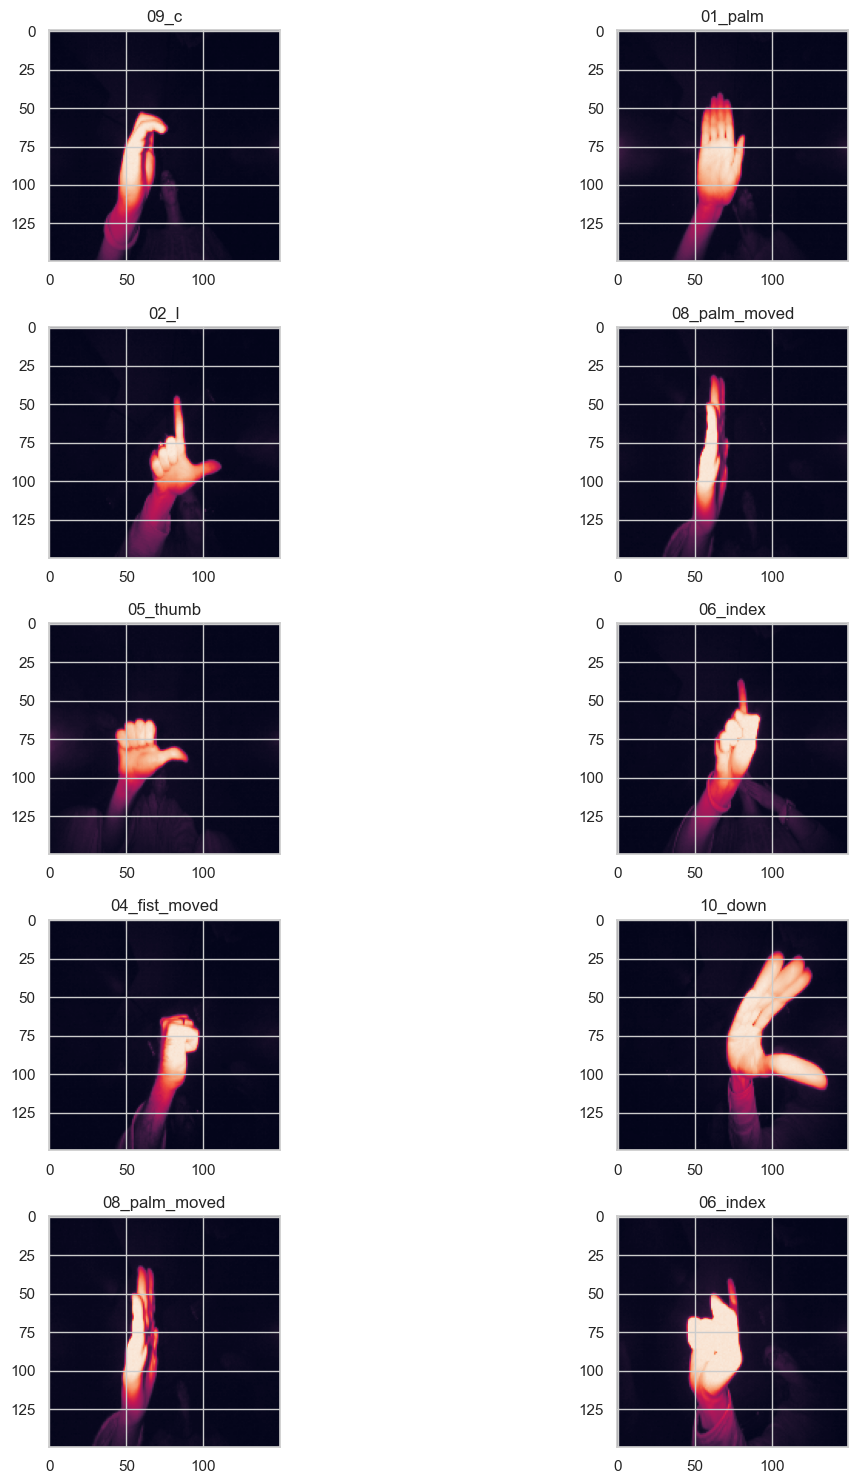

In [7]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()
plt.show()

In [8]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255


In [9]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

In [10]:
#Building a model.
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

model

C:\Users\Md\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


<Sequential name=sequential, built=True>

In [11]:
batch_size = 128
epochs = 10

checkpoint = ModelCheckpoint(
    './base.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq='epoch'  # Save the model checkpoint after each epoch
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)

tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False
)

csvlogger = CSVLogger(
    filename="training_csv.log",
    separator=",",
    append=False
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, tensorboard, csvlogger, reduce_lr]


In [12]:
from keras.optimizers import Adam

# Create Adam optimizer instance with the desired learning rate
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with the Adam optimizer instance
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,981,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,144,714 (15.81 MB)

 Trainable params: 4,144,714 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Training the Model.
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7163 - loss: 0.8595
Epoch 1: val_loss improved from inf to 0.01404, saving model to ./base.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7178 - loss: 0.8551 - val_accuracy: 0.9966 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9980 - loss: 0.0068
Epoch 2: val_loss improved from 0.01404 to 0.00196, saving model to ./base.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9996 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9994 - loss: 0.0030
Epoch 3: val_loss did not improve from 0.00196
118/118 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9992 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9990 - loss: 0.0026
Epoch 4: val_loss did not imp

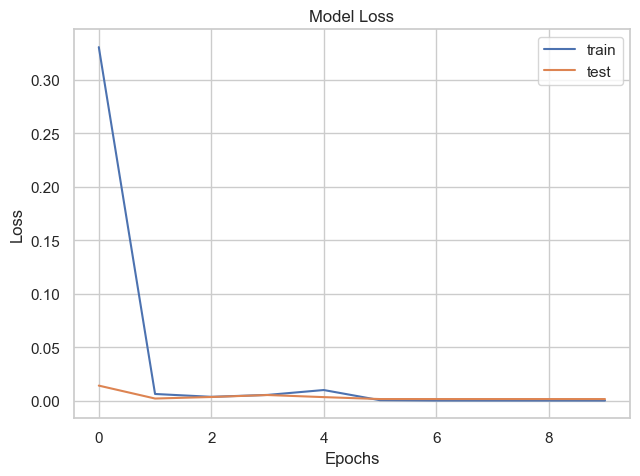

In [17]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

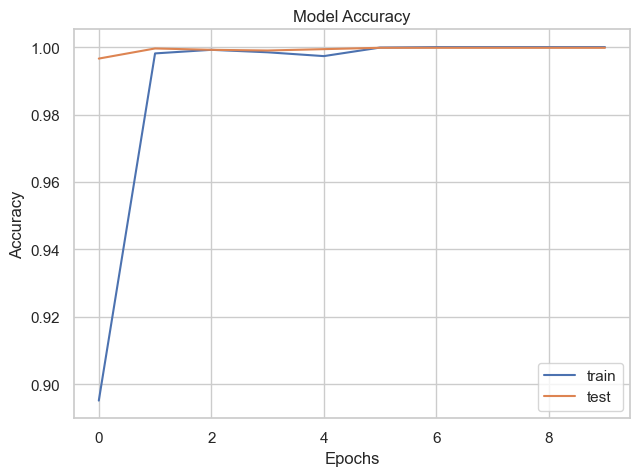

In [18]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()